In [ ]:
from google.colab import drive
import os, sys

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 드라이브 접근
%cd /content/drive/MyDrive/

# 미션 수행을 위한 폴더 생성
!mkdir -p Mission3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


# Mission 3. 패션 스타일 선호 여부 예측

## Mission 3-1

### (1) Item-based filtering

#### 데이터 준비: item-user matrix 생성

In [ ]:
import pandas as pd

# Mission2-2에서 생성한 top100 선호도 데이터 로드
t_top100_pref = pd.read_csv('Mission2/top100_train_preference.csv')
v_top100_pref = pd.read_csv('Mission2/top100_val_preference.csv')

# 성능 측정을 위해 "응답자 ID"와 "파일명"을 기준으로 중복된 행만 사용
dup_top100_pref = pd.merge(v_top100_pref, t_top100_pref, on=['응답자 ID', '파일명', '스타일 선호 여부'], how='inner')

# 결과 확인
print(f"원본 v_top100_pref 행 수: {len(v_top100_pref)}")
print(f"중복된 행 수: {len(dup_top100_pref)}")

원본 v_top100_pref 행 수: 1100
중복된 행 수: 646


In [ ]:
# 데이터의 형태 확인
dup_top100_pref.head()

,응답자 ID,파일명,스타일 선호 여부
0,368,W_04678_50_ivy_M.jpg,스타일 선호
1,368,W_01703_00_metrosexual_M.jpg,스타일 선호
2,368,W_15340_50_ivy_M.jpg,스타일 비선호
3,368,W_06551_60_mods_M.jpg,스타일 비선호
4,368,W_12817_50_ivy_M.jpg,스타일 선호


In [ ]:
# train 데이터를 기반으로 item-user Martix 생성
def make_item_user_matrix(df):
    # 스타일 선호 여부를 1과 -1으로 변환
    df['스타일 선호 여부'] = df['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

    # 선호도 정보를 사용하여 user-item matrix 생성
    user_item_matrix = df.pivot_table(index='응답자 ID', columns='파일명', values='스타일 선호 여부')

    # item-based filtering을 위해 행렬을 전치하여 item-user matrix로 변환
    item_user_matrix = user_item_matrix.T

    # 평가하지 않은 item을 확인하기 위해 마스킹 정보 기록
    mask = item_user_matrix.isna()

    # 결측치 0으로 채우기
    item_user_matrix.fillna(0, inplace=True)

    return item_user_matrix, mask

t_item_user_matrix, t_mask = make_item_user_matrix(t_top100_pref)

In [ ]:
t_item_user_matrix      # train 데이터의 item-user matrix 확인

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
파일명,,,,,,,,,,,,,,,,,,,,,
T_00253_60_popart_W.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
T_00456_10_sportivecasual_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
T_00588_10_sportivecasual_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
T_00770_60_minimal_W.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
T_00893_90_hiphop_W.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W_71923_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
W_71933_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
W_71934_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### 유사도 계산: Item 간 유사도를 계산하여 비슷한 아이템을 찾음

In [ ]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

t_item_similarity_matrix = cosine_similarity(t_item_user_matrix)

# 유사도 행렬을 DataFrame으로 변환하여 쉽게 조작할 수 있도록 함
t_item_similarity_df = pd.DataFrame(t_item_similarity_matrix, index=t_item_user_matrix.index, columns=t_item_user_matrix.index)

# 아이템 유사도 행렬 확인
t_item_similarity_df

파일명,T_00253_60_popart_W.jpg,T_00456_10_sportivecasual_M.jpg,T_00588_10_sportivecasual_M.jpg,T_00770_60_minimal_W.jpg,T_00893_90_hiphop_W.jpg,T_01322_19_normcore_M.jpg,T_01883_10_sportivecasual_M.jpg,T_02527_10_sportivecasual_M.jpg,T_02558_19_normcore_M.jpg,T_02820_10_sportivecasual_W.jpg,...,W_68175_19_normcore_W.jpg,W_68199_10_sportivecasual_W.jpg,W_71920_60_mods_M.jpg,W_71921_60_mods_M.jpg,W_71922_60_mods_M.jpg,W_71923_60_mods_M.jpg,W_71933_60_mods_M.jpg,W_71934_60_mods_M.jpg,W_71935_60_mods_M.jpg,W_71936_60_mods_M.jpg
파일명,,,,,,,,,,,,,,,,,,,,,
T_00253_60_popart_W.jpg,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00456_10_sportivecasual_M.jpg,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00588_10_sportivecasual_M.jpg,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00770_60_minimal_W.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
T_00893_90_hiphop_W.jpg,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W_71923_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
W_71933_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
W_71934_60_mods_M.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0


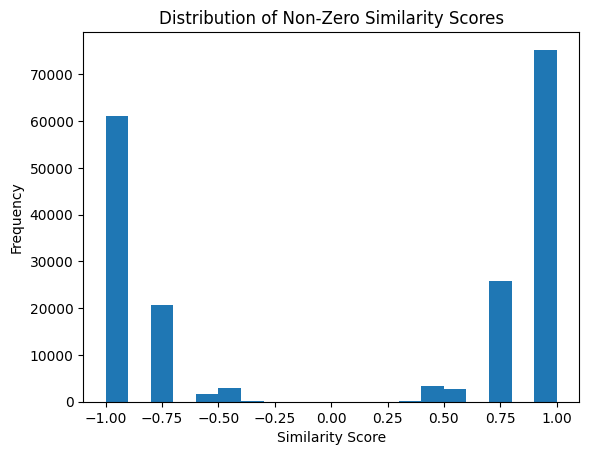

In [ ]:
# 유사도 임계값 설정을 위한 유사도 행렬의 분포 살펴보기
import numpy as np
import matplotlib.pyplot as plt

# 대각선 요소(자신과의 유사도는 1)와 0(item에 비해 설문의 수가 적어서 0이 너무 많음)은 제외
similarities = t_item_similarity_df.values[~np.eye(t_item_similarity_df.shape[0], dtype=bool)]
non_zero_similarities = similarities[similarities != 0]

# 유사도 행렬 분포 시각화
plt.hist(non_zero_similarities, bins=20)
plt.title("Distribution of Non-Zero Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

> 유사도 행렬의 분포를 보았을 때, `유사한 Item`을 확실히 판별하는 기준으로써 0.7이 합리적이라고 판단

#### 추천

In [ ]:
def predict_rating(dup_top100_pref, item_similarity_df, mask_df, item_user_matrix):
    predicted_ratings = []      # 아이템의 평점 예측 정보

    for i in range(len(dup_top100_pref)):
        user_id = dup_top100_pref.iloc[i, 0]
        item = dup_top100_pref.iloc[i, 1]

        # user가 평가한 아이템의 index(파일명)
        rated_items = mask_df[user_id].loc[mask_df[user_id] == False].index

        # 평가한 아이템들과의 유사도 행렬
        similar_items = item_similarity_df[item].loc[rated_items]

        # 유사도가 임계값 이상인 항목들만 추출
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items[similar_items >= 0.7]     # 임계값: 0.7

        # top_similar_items의 유사도에 사용자 평점을 가중 평균하여 예측 평점 계산
        weighted_ratings_sum = 0    # 가중 평점의 합(분자)
        similarity_sum = 0          # 모든 유사도의 합(분모)

        # 사용자가 평가한 아이템만 고려하여 선호도 예측
        for similar_item in top_similar_items.index:
            if similar_item == item:    # 자기 자신은 제외
                continue
            similarity = top_similar_items[similar_item]
            rating = item_user_matrix[[user_id]].loc[similar_item].values
            weighted_ratings_sum += similarity * rating
            similarity_sum += similarity

        if similarity_sum != 0:
            predicted_rating = weighted_ratings_sum / similarity_sum
        else:
            predicted_rating = 0

        # 예측된 선호도 저장
        predicted_ratings.append([user_id, item, predicted_rating])

    # 다루기 쉽게 DataFrame으로 변환
    predicted_df = pd.DataFrame(predicted_ratings, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return predicted_df

# 함수 실행
predicted_ratings = predict_rating(dup_top100_pref, t_item_similarity_df, t_mask, t_item_user_matrix)

In [ ]:
# 실제 스타일 선호 여부와 예측된 선호 여부 비교
total_dup_pref = dup_top100_pref.merge(predicted_ratings, on=['응답자 ID', '파일명'], how='left')
total_dup_pref['스타일 선호 여부'] = total_dup_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

# 확실히 선호하는 경우만 1로, 그렇지 않은 경우 -1로 변환(0으로 예측된 경우도 -1로 생각함)
total_dup_pref['예측된 선호도'] = total_dup_pref['예측된 선호도'].apply(lambda x: 1 if x > 0 else -1)

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
precision = precision_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
recall = recall_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# 실제 선호 여부 및 예측된 선호도 확인
total_dup_pref

Accuracy: 0.9737, Precision: 1.0000, Recall: 0.9306


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1,-1
1,368,W_01703_00_metrosexual_M.jpg,1,1
2,368,W_15340_50_ivy_M.jpg,-1,-1
3,368,W_06551_60_mods_M.jpg,-1,-1
4,368,W_12817_50_ivy_M.jpg,1,-1
...,...,...,...,...
641,67975,W_07074_00_metrosexual_M.jpg,1,1
642,67975,W_17747_80_bold_M.jpg,-1,-1
643,67975,W_17738_80_bold_M.jpg,1,1
644,67975,T_21986_70_hippie_M.jpg,-1,-1


### (2) User-based filtering

#### 데이터 준비: user-item matrix 생성

In [ ]:
import pandas as pd

# top100 선호도 데이터 로드
t_top100_pref = pd.read_csv('Mission2/top100_train_preference.csv')
v_top100_pref = pd.read_csv('Mission2/top100_val_preference.csv')

# 성능 측정을 위해 "응답자 ID"와 "파일명"을 기준으로 중복된 행만 사용
dup_top100_pref = pd.merge(v_top100_pref, t_top100_pref, on=['응답자 ID', '파일명', '스타일 선호 여부'], how='inner')

# 결과 확인
print(f"원본 v_top100_pref 행 수: {len(v_top100_pref)}")
print(f"중복된 행 수: {len(dup_top100_pref)}")

원본 v_top100_pref 행 수: 1100
중복된 행 수: 646


In [ ]:
# 데이터의 형태 확인
dup_top100_pref.head()

,응답자 ID,파일명,스타일 선호 여부
0,368,W_04678_50_ivy_M.jpg,스타일 선호
1,368,W_01703_00_metrosexual_M.jpg,스타일 선호
2,368,W_15340_50_ivy_M.jpg,스타일 비선호
3,368,W_06551_60_mods_M.jpg,스타일 비선호
4,368,W_12817_50_ivy_M.jpg,스타일 선호


In [ ]:
def make_user_item_matrix(df):
    # 스타일 선호 여부를 1과 0으로 변환
    df['스타일 선호 여부'] = df['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

    # 선호도 정보를 사용하여 user-item matrix 생성
    user_item_matrix = df.pivot_table(index='응답자 ID', columns='파일명', values='스타일 선호 여부')

    # 평가하지 않은 user을 확인하기 위해 마스킹 정보 기록
    mask = user_item_matrix.isna()

    # 결측치 0으로 채우기
    user_item_matrix.fillna(0, inplace=True)

    return user_item_matrix, mask

t_user_item_matrix, t_mask = make_user_item_matrix(t_top100_pref)

In [ ]:
t_user_item_matrix      # train 데이터의 user-item matrix 확인

파일명,T_00253_60_popart_W.jpg,T_00456_10_sportivecasual_M.jpg,T_00588_10_sportivecasual_M.jpg,T_00770_60_minimal_W.jpg,T_00893_90_hiphop_W.jpg,T_01322_19_normcore_M.jpg,T_01883_10_sportivecasual_M.jpg,T_02527_10_sportivecasual_M.jpg,T_02558_19_normcore_M.jpg,T_02820_10_sportivecasual_W.jpg,...,W_68175_19_normcore_W.jpg,W_68199_10_sportivecasual_W.jpg,W_71920_60_mods_M.jpg,W_71921_60_mods_M.jpg,W_71922_60_mods_M.jpg,W_71923_60_mods_M.jpg,W_71933_60_mods_M.jpg,W_71934_60_mods_M.jpg,W_71935_60_mods_M.jpg,W_71936_60_mods_M.jpg
응답자 ID,,,,,,,,,,,,,,,,,,,,,
368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66469,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66592,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 유사도 계산: User 간 유사도를 계산하여 비슷한 사용자를 찾음

In [ ]:
# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

t_user_similarity_matrix = cosine_similarity(t_user_item_matrix)

# 유사도 행렬을 DataFrame으로 변환하여 쉽게 조작할 수 있도록 함
t_user_similarity_df = pd.DataFrame(t_user_similarity_matrix, index=t_user_item_matrix.index, columns=t_user_item_matrix.index)

# User 유사도 행렬 확인
t_user_similarity_df

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
응답자 ID,,,,,,,,,,,,,,,,,,,,,
368,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.022473,...,0.022990,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.022751,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7658,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7905,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.02299,-0.023531,0.000000,...,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9096,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66469,0.0,0.0,0.0,0.0,0.0,0.0,0.022751,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66513,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66592,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.021979,0.0,0.0,0.0,0.0,1.0,0.0,0.0


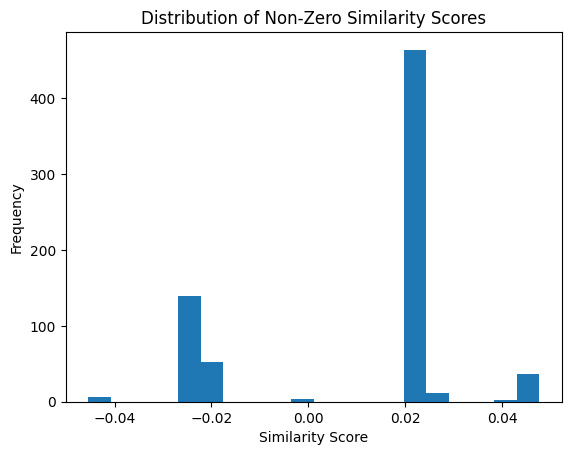

In [ ]:
# 임계값 설정을 위한 유사도 행렬의 분포 살펴보기
import numpy as np
import matplotlib.pyplot as plt

# 대각선 요소(자신과의 유사도는 1)와 0(item에 비해 설문의 수가 적어서 0이 너무 많음) 제외
similarities = t_user_similarity_df.values[~np.eye(t_user_similarity_df.shape[0], dtype=bool)]
non_zero_similarities = similarities[similarities != 0]

# 유사도 행렬 분포 시각화
plt.hist(non_zero_similarities, bins=20)
plt.title("Distribution of Non-Zero Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

#### 추천

In [ ]:
def predict_rating(dup_top100_pref, user_similarity_df, mask_df, user_item_matrix):
    predicted_ratings = []      # 아이템의 평점 예측 정보

    for i in range(len(dup_top100_pref)):
        user_id = dup_top100_pref.iloc[i, 0]
        item = dup_top100_pref.iloc[i, 1]

        # 해당 item을 평가한 user의 index(userID)
        rated_user = mask_df[item].loc[mask_df[item] == False].index

        # 평가한 user들과의 유사도 행렬
        similar_users = user_similarity_df[user_id].loc[rated_user]

        # 유사도가 임계값 이상인 항목들만 추출
        similar_users = similar_users.sort_values(ascending=False)
        top_similar_users = similar_users[similar_users >= 0.7]

        # top_similar_users의 유사도에 사용자 평점을 가중 평균하여 예측 평점 계산
        weighted_ratings_sum = 0    # 가중 평점의 합(분자)
        similarity_sum = 0          # 모든 유사도의 합(분모)

        # item을 평가한 user만 고려하여 선호도 예측
        for similar_user in top_similar_users.index:
            if similar_user == user_id:    # 자기 자신은 제외
                continue
            similarity = top_similar_users[similar_user]
            rating = user_item_matrix[[item]].loc[similar_user].values
            weighted_ratings_sum += similarity * rating
            similarity_sum += similarity

        if similarity_sum != 0:
            predicted_rating = weighted_ratings_sum / similarity_sum
        else:
            predicted_rating = 0

        # 예측된 선호도 저장
        predicted_ratings.append([user_id, item, predicted_rating])

    # 다루기 쉽게 DataFrame으로 변환
    predicted_df = pd.DataFrame(predicted_ratings, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return predicted_df

# 함수 실행
predicted_ratings = predict_rating(dup_top100_pref, t_user_similarity_df, t_mask, t_user_item_matrix)

In [ ]:
# 실제 스타일 선호 여부와 예측된 선호 여부 비교
total_dup_pref = dup_top100_pref.merge(predicted_ratings, on=['응답자 ID', '파일명'], how='left')
total_dup_pref['스타일 선호 여부'] = total_dup_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

# 확실히 선호하는 경우만 1로, 그렇지 않은 경우 -1로 변환
total_dup_pref['예측된 선호도'] = total_dup_pref['예측된 선호도'].apply(lambda x: 1 if x > 0 else -1)

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
precision = precision_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])
recall = recall_score(total_dup_pref['스타일 선호 여부'], total_dup_pref['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# 실제 선호 여부 및 예측된 선호도 확인
total_dup_pref

Accuracy: 0.6207, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_04678_50_ivy_M.jpg,1,-1
1,368,W_01703_00_metrosexual_M.jpg,1,-1
2,368,W_15340_50_ivy_M.jpg,-1,-1
3,368,W_06551_60_mods_M.jpg,-1,-1
4,368,W_12817_50_ivy_M.jpg,1,-1
...,...,...,...,...
641,67975,W_07074_00_metrosexual_M.jpg,1,-1
642,67975,W_17747_80_bold_M.jpg,-1,-1
643,67975,W_17738_80_bold_M.jpg,1,-1
644,67975,T_21986_70_hippie_M.jpg,-1,-1


#### 결과 해석

> user 간의 유사도 행렬을 살펴보면 유사도 값이 높은 user가 전혀 존재하지 않음을 알 수 있다.

In [ ]:
# user 간 유사도 행렬
t_user_similarity_df

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
응답자 ID,,,,,,,,,,,,,,,,,,,,,
368,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.022473,...,0.022990,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.022751,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7658,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7905,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.02299,-0.023531,0.000000,...,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9096,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66469,0.0,0.0,0.0,0.0,0.0,0.0,0.022751,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66513,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
66592,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.021979,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# 유사도가 높은(0.7 이상) user 정보를 확인
import numpy as np
user_similar_df = t_user_similarity_df.copy()

# 대각 행렬을 0으로 만들기
np.fill_diagonal(user_similar_df.values, 0)

# 유사도가 0.7 이상인 요소만 남기고 나머지는 0으로 설정
df_filtered = user_similar_df.where(user_similar_df >= 0.7, 0)

# 각 행에서 0이 아닌 값을 가진 열만 선택
result = df_filtered.apply(lambda x: x[x != 0])

# 결과 출력
result

응답자 ID,368,837,7658,7905,9096,20768,21432,22324,28371,28571,...,64633,64662,64747,65071,65139,66469,66513,66592,66731,67975
응답자 ID,,,,,,,,,,,,,,,,,,,,,


> User 간 유사도 행렬에서 가장 높은 값을 확인하면 약 0.047이다.

In [ ]:
# 가장 높은 유사도를 가진 값 확인
user_similar_df.values.max()

0.04767312946227962

> 즉, 서로 유사도가 높은 user는 단 1명도 없음을 알 수 있다.<br>
> 이유를 추측해보면 현재 데이터가 item에 비해 user의 수가 너무 적고(100명), 설문 응답 개수 또한 적은 편이다. <br>
> 즉, `데이터 희소성 문제`로 인해 유사한 user가 전혀 없다고 판단하는 것으로 보인다.

## Mission 3-2

### train data로부터 feature vector 추출

In [ ]:
# 런타임 유형을 변경할 경우 다시 마운트를 실행
from google.colab import drive
import os, sys

# 구글 드라이브 마운트
drive.mount('/content/drive')

# 드라이브 접근
%cd /content/drive/MyDrive/

# 미션 수행을 위한 폴더 생성
!mkdir -p Mission3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# 필요 패키지 import
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms


# 모델 재현을 위한 랜덤시드 고정
def set_random_seed(seed_value=42):
    # Python의 기본 난수 시드 설정
    random.seed(seed_value)
    # NumPy 난수 시드 설정
    np.random.seed(seed_value)
    # PyTorch 난수 시드 설정 (CPU)
    torch.manual_seed(seed_value)
    # PyTorch 난수 시드 설정 (GPU)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    # CuDNN 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

In [ ]:
import torchvision.models as models

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 학습된 가중치로 모델 불러오기
model = models.resnet18(weights=None, num_classes=31)

# Mission1에서 Loss가 가장 적었던 모델의 가중치 로드
model.load_state_dict(torch.load('Mission1/best_loss_exp/best_model.pth', weights_only=True))
model = model.to(device)
model.eval()    # 학습을 하는 것이 아니므로 eval 모드로 설정

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 특징 추출을 위한 Class 정의
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])    # 마지막 fc layer 제외

    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)

# 특징 추출 객체 선언
feature_extractor = FeatureExtractor(model)
feature_extractor = feature_extractor.to(device)

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# 이미지 전처리 함수
def _preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 배치 차원 추가

# feature vector 추출 함수
def _extract_features(image_path, device, feature_extractor):
    image = _preprocess_image(image_path).to(device)
    with torch.no_grad():
        features = feature_extractor(image)
    return features.cpu().numpy().flatten()

# 여러 이미지로부터 feature vector 추출 (Colab I/O 접근이 너무 느리기 떄문에 멀티쓰레드 사용, os.cpu_count() == 12 -> L4 GPU이어야 원활한 실행 가능)
def extract_features_from_images(dir_path, image_list, device, feature_extractor):
    features = {}
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(_extract_features, os.path.join(dir_path, img), device, feature_extractor): img for img in image_list}

        for future in tqdm(as_completed(futures), total=len(futures), desc="Extracting features"):
            img = futures[future]
            try:
                features[img] = np.array(future.result())
            except Exception as e:
                print(f"{img} 처리 중 오류 발생: {e}")
    return features

def extract_and_save(state='train', save=True):
    img_path = './dataset/origin_dataset'
    if state == 'train':
        dir_path = os.path.join(img_path, 'training_image')
    else:
        dir_path = os.path.join(img_path, 'validation_image')
    img_list = os.listdir(dir_path)

    extracted_features = extract_features_from_images(dir_path, img_list, device, feature_extractor)

    # feature의 shape 확인
    print(f"이미지 수: {len(extracted_features)}, feature shape: {extracted_features[img_list[0]].shape}")

    # 추출된 feature vector를 DataFrame으로 변환 후 저장
    feature_vectors = pd.DataFrame(extracted_features).T
    if save:
        os.makedirs('Mission3', exist_ok=True)
        feature_vectors.to_csv(f'Mission3/{state}_feature_vectors.csv')

    return feature_vectors

# feature vector 추출 및 저장
t_feature_vectors = extract_and_save('train', save=True)
v_feature_vectors = extract_and_save('val', save=True)

Extracting features: 100%|██████████| 4070/4070 [05:10<00:00, 13.09it/s]


이미지 수: 4070, feature shape: (512,)


Extracting features: 100%|██████████| 951/951 [01:16<00:00, 12.36it/s]


이미지 수: 951, feature shape: (512,)


### feature vector의 이미지 유사도를 활용한 스타일 선호 예측

In [ ]:
import numpy as np
import pandas as pd

# Mission2-2에서 생성한 top100 선호도 데이터 로드
t_top100_pref = pd.read_csv('Mission2/top100_train_preference.csv')
v_top100_pref = pd.read_csv('Mission2/top100_val_preference.csv')

# 선호도 여부를 1과 -1로 변환(Mission 3-1과 동일하게 적용)
t_top100_pref['스타일 선호 여부'] = t_top100_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)
v_top100_pref['스타일 선호 여부'] = v_top100_pref['스타일 선호 여부'].apply(lambda x: 1 if x == '스타일 선호' else -1)

In [ ]:
def feature_preprocessing(csv_path):
    feature_vectors = pd.read_csv(csv_path, index_col=0)        # feature vector 데이터 불러오기
    feature_vectors['feature_vector'] = feature_vectors.values.tolist()      # 512차원의 feature vector를 하나의 list로 변환

    # '파일명'과 'feature_vector' 열만 남기기
    feature_reset = feature_vectors.reset_index().rename(columns={'index': '파일명'})
    feature_simplified = feature_reset[['파일명', 'feature_vector']]

    return feature_simplified

# 저장된 feature vector csv 파일 경로
t_feature_simplified = feature_preprocessing('Mission3/train_feature_vectors.csv')
v_feature_simplified = feature_preprocessing('Mission3/val_feature_vectors.csv')

In [ ]:
# train과 validation 데이터의 feature vector를 이용하여 유사도 행렬 생성
from sklearn.metrics.pairwise import cosine_similarity

# feature_vectors를 numpy 배열로 변환
train_features = np.stack(t_feature_simplified['feature_vector'].values)
val_features = np.stack(v_feature_simplified['feature_vector'].values)

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(train_features, val_features)

# 결과를 DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix,
                             index=t_feature_simplified['파일명'],
                             columns=v_feature_simplified['파일명'])

# train-validation 이미지 간 유사도 행렬 확인
similarity_df

파일명,W_20598_70_military_W.jpg,W_02498_50_feminine_W.jpg,W_11610_90_grunge_W.jpg,W_47169_70_hippie_W.jpg,W_05628_00_cityglam_W.jpg,W_38588_19_genderless_W.jpg,W_22510_80_powersuit_W.jpg,W_30988_90_kitsch_W.jpg,W_39164_00_oriental_W.jpg,W_44330_10_sportivecasual_W.jpg,...,W_16067_80_bold_M.jpg,W_20593_70_punk_W.jpg,W_41341_19_lounge_W.jpg,W_29693_19_normcore_M.jpg,W_17783_80_bold_M.jpg,W_24517_70_hippie_M.jpg,W_12635_70_hippie_M.jpg,W_12817_50_ivy_M.jpg,W_25649_19_normcore_M.jpg,W_25790_90_hiphop_M.jpg
파일명,,,,,,,,,,,,,,,,,,,,,
W_13846_60_minimal_W.jpg,0.578833,0.652536,0.407351,0.390600,0.593423,0.616600,0.698037,0.452228,0.706288,0.402619,...,0.799044,0.712388,0.747899,0.587182,0.657697,0.284166,0.278237,0.427809,0.594407,0.430533
W_10981_50_feminine_W.jpg,0.758445,0.900691,0.533222,0.578887,0.633572,0.524184,0.584434,0.544127,0.937815,0.525235,...,0.638641,0.720997,0.701771,0.511369,0.634490,0.361793,0.315936,0.462535,0.617854,0.612102
W_14489_19_normcore_W.jpg,0.667769,0.616123,0.684993,0.591835,0.768282,0.678110,0.505030,0.544305,0.671321,0.557363,...,0.584284,0.665826,0.773254,0.647131,0.538943,0.527656,0.530435,0.709773,0.561760,0.502561
W_16836_19_normcore_M.jpg,0.450144,0.412058,0.511955,0.390615,0.493622,0.874314,0.512953,0.498940,0.406927,0.419327,...,0.689034,0.442448,0.497870,0.883176,0.623670,0.532336,0.533661,0.635083,0.487970,0.492199
W_17123_19_normcore_M.jpg,0.470672,0.470980,0.549426,0.514430,0.490963,0.875660,0.521476,0.523792,0.398665,0.453136,...,0.694488,0.430364,0.560454,0.882393,0.678168,0.607623,0.571459,0.590698,0.517074,0.586279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W_25400_19_normcore_M.jpg,0.412683,0.397502,0.447764,0.373020,0.472459,0.853628,0.467378,0.470208,0.398322,0.364277,...,0.642619,0.430696,0.449661,0.833703,0.567004,0.531308,0.527698,0.651332,0.455389,0.468339
W_17108_19_normcore_M.jpg,0.430460,0.448311,0.575467,0.547781,0.576505,0.871043,0.554438,0.611663,0.394036,0.430416,...,0.690477,0.517597,0.546617,0.850023,0.652534,0.610223,0.570484,0.583682,0.561777,0.493322
W_09233_60_mods_M.jpg,0.337876,0.295941,0.374216,0.285780,0.340084,0.630628,0.393971,0.500380,0.346020,0.261456,...,0.588320,0.376860,0.336279,0.514431,0.478550,0.504567,0.484216,0.624612,0.564366,0.414932


기본 통계:
평균: 0.5493
중앙값: 0.5406
표준편차: 0.1402
최소값: 0.1402
최대값: 1.0000


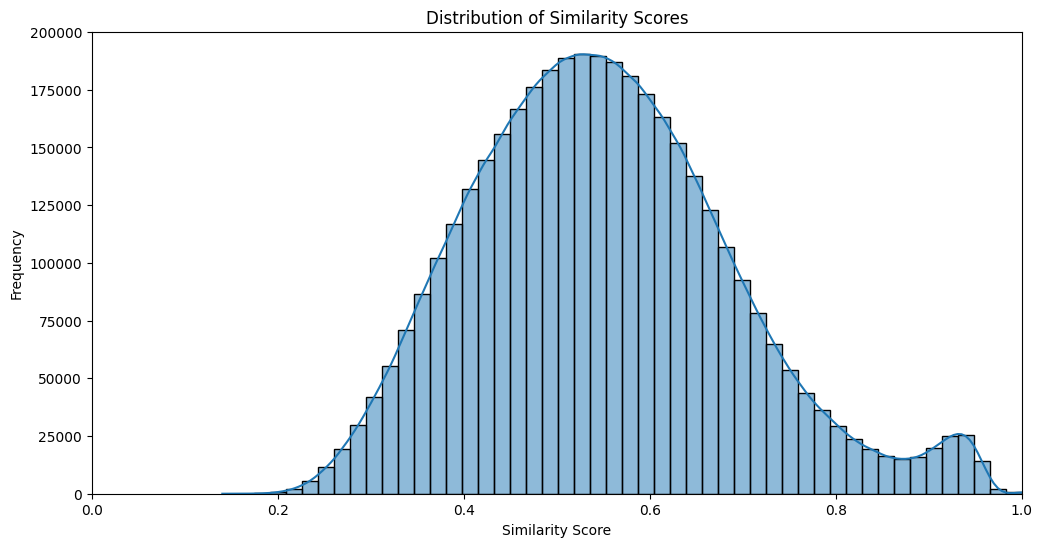

In [ ]:
# 유사한 item의 임계값을 정하기 위한 유사도 행렬의 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

# 모든 유사도 값을 1차원 배열로 변환
similarity_values = similarity_df.values.flatten()

# 기본 통계 출력
print("기본 통계:")
print(f"평균: {similarity_values.mean():.4f}")
print(f"중앙값: {np.median(similarity_values):.4f}")
print(f"표준편차: {similarity_values.std():.4f}")
print(f"최소값: {similarity_values.min():.4f}")
print(f"최대값: {similarity_values.max():.4f}")

# 그래프 설정
plt.figure(figsize=(12, 6))

# 히스토그램과 밀도 플롯 그리기
sns.histplot(similarity_values, kde=True, bins=50)

plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")

# x축 범위 설정
plt.xlim(0, 1)
plt.show()

> 유사도 행렬의 분포와 통계값을 확인한 결과 임계값을 `0.75`로 설정하는 것이 합리적이라고 판단
> - `mean + 1.5 * std = 0.7596` 값을 기준으로 함

#### (1) 유사도 top1의 item만 고려하여 예측

In [ ]:
# 유사도가 가장 높은 item의 선호도를 바탕으로 예측
def _method1(top_similar_items, user_rated_df):
    predicted_rating = user_rated_df.loc[user_rated_df['파일명'] == top_similar_items.index[0]]['스타일 선호 여부'].values[0]
    return predicted_rating

def predict_preference(v_top100_pref, t_top100_pref, similarity_df):
    pred_list = []

    for i in range(len(v_top100_pref)):
        userID = v_top100_pref.iloc[i, 0]
        item = v_top100_pref.iloc[i, 1]

        # userID를 기준으로 해당 유저가 이미 평가한 items의 정보
        user_rated_df = t_top100_pref.loc[t_top100_pref['응답자 ID'] == userID]
        rated_items = user_rated_df['파일명'].values

        # 해당 유저가 이미 평가한 아이템들과 item의 유사도 추출
        similar_items = similarity_df.loc[rated_items, item]

        # 유사도가 가장 높은 item 추출
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items.head(1)

        # 선호도 예측
        predicted_rating = _method1(top_similar_items, user_rated_df)

        # 예측값 저장
        pred_list.append([userID, item, predicted_rating])

    pred_df = pd.DataFrame(pred_list, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return pred_df

# 선호도 예측
pred_df = predict_preference(v_top100_pref, t_top100_pref, similarity_df)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_06864_10_sportivecasual_M.jpg,1
1,368,W_04678_50_ivy_M.jpg,1
2,368,W_16034_80_bold_M.jpg,-1
3,368,W_00551_19_normcore_M.jpg,1
4,368,W_01703_00_metrosexual_M.jpg,1
...,...,...,...
1095,67975,W_17738_80_bold_M.jpg,1
1096,67975,T_21986_70_hippie_M.jpg,-1
1097,67975,T_21988_70_hippie_M.jpg,-1
1098,67975,W_52578_50_ivy_M.jpg,-1


In [ ]:
# v_top100_pref와 merge
merge_df = v_top100_pref.merge(pred_df, on=['응답자 ID', '파일명'], how='left')

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
precision = precision_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
recall = recall_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

merge_df

Accuracy: 0.8191, Precision: 0.7763, Recall: 0.7710


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_06864_10_sportivecasual_M.jpg,1,1
1,368,W_04678_50_ivy_M.jpg,1,1
2,368,W_16034_80_bold_M.jpg,-1,-1
3,368,W_00551_19_normcore_M.jpg,1,1
4,368,W_01703_00_metrosexual_M.jpg,1,1
...,...,...,...,...
1095,67975,W_17738_80_bold_M.jpg,1,1
1096,67975,T_21986_70_hippie_M.jpg,-1,-1
1097,67975,T_21988_70_hippie_M.jpg,1,-1
1098,67975,W_52578_50_ivy_M.jpg,1,-1


#### (2) 유사도가 높은 상위 n개 items의 선호도를 고려하여 voting

In [ ]:
# 유사도 상위 15개 items의 선호도를 바탕으로 voting하여 예측
def _method2(top_similar_items, user_rated_df):
    pref_lists = []
    for similar_item in top_similar_items.index:
        rating = user_rated_df.loc[user_rated_df['파일명']==similar_item]['스타일 선호 여부'].values[0]
        pref_lists.append(rating)
    # pref_lists에서 개수가 가장 많은 선호도를 값을 예측으로 사용
    predicted_rating = max(pref_lists, key=pref_lists.count)

    return predicted_rating

def predict_preference(v_top100_pref, t_top100_pref, similarity_df):
    pred_list = []

    for i in range(len(v_top100_pref)):
        userID = v_top100_pref.iloc[i, 0]
        item = v_top100_pref.iloc[i, 1]

        # userID를 기준으로 해당 유저가 이미 평가한 items의 정보
        user_rated_df = t_top100_pref.loc[t_top100_pref['응답자 ID'] == userID]
        rated_items = user_rated_df['파일명'].values

        # 해당 유저가 이미 평가한 아이템들과 item의 유사도 추출
        similar_items = similarity_df.loc[rated_items, item]

        # 유사도 상위 15개의 item 추출
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items.head(15)

        # 선호도 예측
        predicted_rating = _method2(top_similar_items, user_rated_df)

        # 예측값 저장
        pred_list.append([userID, item, predicted_rating])

    pred_df = pd.DataFrame(pred_list, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return pred_df

# 선호도 예측
pred_df = predict_preference(v_top100_pref, t_top100_pref, similarity_df)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_06864_10_sportivecasual_M.jpg,-1
1,368,W_04678_50_ivy_M.jpg,1
2,368,W_16034_80_bold_M.jpg,-1
3,368,W_00551_19_normcore_M.jpg,-1
4,368,W_01703_00_metrosexual_M.jpg,1
...,...,...,...
1095,67975,W_17738_80_bold_M.jpg,-1
1096,67975,T_21986_70_hippie_M.jpg,-1
1097,67975,T_21988_70_hippie_M.jpg,-1
1098,67975,W_52578_50_ivy_M.jpg,-1


In [ ]:
# v_top100_pref와 merge
merge_df = v_top100_pref.merge(pred_df, on=['응답자 ID', '파일명'], how='left')

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
precision = precision_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
recall = recall_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

merge_df

Accuracy: 0.6909, Precision: 0.6384, Recall: 0.5283


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_06864_10_sportivecasual_M.jpg,1,-1
1,368,W_04678_50_ivy_M.jpg,1,1
2,368,W_16034_80_bold_M.jpg,-1,-1
3,368,W_00551_19_normcore_M.jpg,1,-1
4,368,W_01703_00_metrosexual_M.jpg,1,1
...,...,...,...,...
1095,67975,W_17738_80_bold_M.jpg,1,-1
1096,67975,T_21986_70_hippie_M.jpg,-1,-1
1097,67975,T_21988_70_hippie_M.jpg,1,-1
1098,67975,W_52578_50_ivy_M.jpg,1,-1


#### (3) 사용자 선호도 정보에 유사도를 가중 평균하여 예측

In [ ]:
# top_similar_items의 유사도에 사용자 평점을 가중 평균하여 예측 평점 계산(강의에서 사용한 방법)
def _method3(top_similar_items, user_rated_df):
    weighted_ratings_sum = 0    # 가중 평점의 합(분자)
    similarity_sum = 0          # 모든 유사도의 합(분모)

    # 사용자가 평가한 아이템 중 top_similar_items를 고려하여 선호도 예측
    for similar_item in top_similar_items.index:
        similarity = top_similar_items[similar_item]
        rating = user_rated_df.loc[user_rated_df['파일명'] == similar_item]['스타일 선호 여부'].values[0]
        weighted_ratings_sum += similarity * rating
        similarity_sum += similarity

    if similarity_sum != 0:
        predicted_rating = weighted_ratings_sum / similarity_sum
    else:
        predicted_rating = 0

    return predicted_rating

def predict_preference(v_top100_pref, t_top100_pref, similarity_df):
    pred_list = []

    for i in range(len(v_top100_pref)):
        userID = v_top100_pref.iloc[i, 0]
        item = v_top100_pref.iloc[i, 1]

        # userID를 기준으로 해당 유저가 이미 평가한 items의 정보
        user_rated_df = t_top100_pref.loc[t_top100_pref['응답자 ID'] == userID]
        rated_items = user_rated_df['파일명'].values

        # 해당 유저가 이미 평가한 아이템들과 item의 유사도 추출
        similar_items = similarity_df.loc[rated_items, item]

        # 유사도가 임계값 이상인 항목들만 추출(!임계값 변경 가능)
        similar_items = similar_items.sort_values(ascending=False)
        top_similar_items = similar_items[similar_items >= 0.75]    # 임계값: 0.75

        # 선호도 예측(강의에서 사용한 방법 사용)
        predicted_rating = _method3(top_similar_items, user_rated_df)

        # 예측값 저장
        pred_list.append([userID, item, predicted_rating])

    pred_df = pd.DataFrame(pred_list, columns=['응답자 ID', '파일명', '예측된 선호도'])

    return pred_df

# 선호도 예측
pred_df = predict_preference(v_top100_pref, t_top100_pref, similarity_df)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_06864_10_sportivecasual_M.jpg,-0.001472
1,368,W_04678_50_ivy_M.jpg,0.340583
2,368,W_16034_80_bold_M.jpg,-0.332617
3,368,W_00551_19_normcore_M.jpg,0.197463
4,368,W_01703_00_metrosexual_M.jpg,0.033871
...,...,...,...
1095,67975,W_17738_80_bold_M.jpg,-0.577791
1096,67975,T_21986_70_hippie_M.jpg,-0.603113
1097,67975,T_21988_70_hippie_M.jpg,-0.093612
1098,67975,W_52578_50_ivy_M.jpg,-0.463443


< 기본 통계 >
개수: 1100 | 평균: -0.1831 | 중앙값: -0.1630 | 표준편차: 0.5522


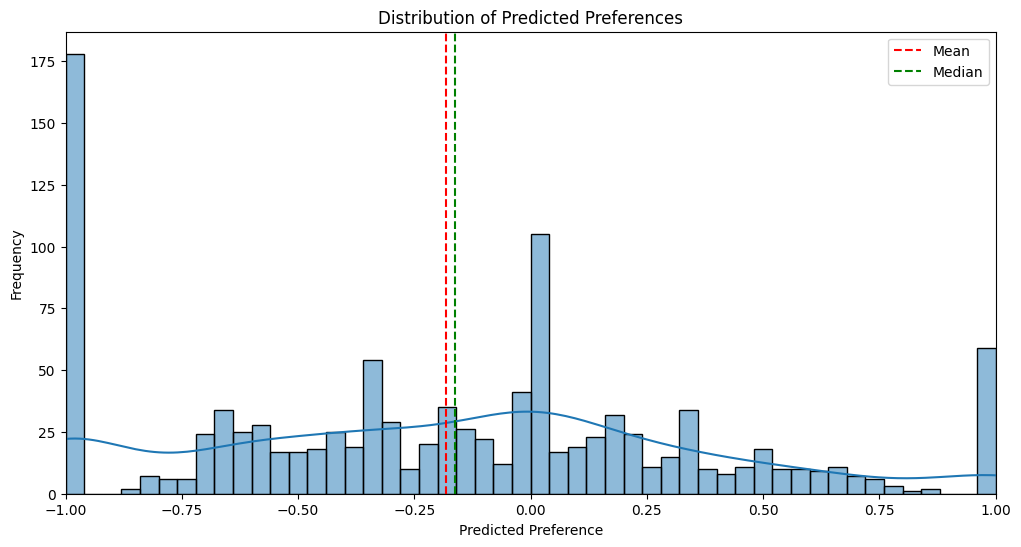

In [ ]:
# 예측된 선호도를 결정할 임계값 계산을 위한 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 기본 통계 계산
stats = pred_df['예측된 선호도'].describe()

# 기본 통계 출력
print("< 기본 통계 >")
print(f"개수: {stats['count']:.0f} | 평균: {stats['mean']:.4f} | 중앙값: {stats['50%']:.4f} | 표준편차: {stats['std']:.4f}")


# 그래프 설정
plt.figure(figsize=(12, 6))

# 히스토그램과 KDE 플롯
sns.histplot(data=pred_df, x='예측된 선호도', kde=True, bins=50)

# 평균과 중앙값 표시
plt.axvline(stats['mean'], color='r', linestyle='--', label='Mean')
plt.axvline(stats['50%'], color='g', linestyle='--', label='Median')

plt.title("Distribution of Predicted Preferences")
plt.xlabel("Predicted Preference")
plt.ylabel("Frequency")
plt.legend()

# x축 범위 설정
plt.xlim(-1, 1)

plt.show()

In [ ]:
# pred_df의 값이 0보다 높은 경우만 확실하게 '스타일 선호'로 분류
pred_df['예측된 선호도'] = pred_df['예측된 선호도'].apply(lambda x: 1 if x > 0 else -1)
pred_df

,응답자 ID,파일명,예측된 선호도
0,368,W_06864_10_sportivecasual_M.jpg,-1
1,368,W_04678_50_ivy_M.jpg,1
2,368,W_16034_80_bold_M.jpg,-1
3,368,W_00551_19_normcore_M.jpg,1
4,368,W_01703_00_metrosexual_M.jpg,1
...,...,...,...
1095,67975,W_17738_80_bold_M.jpg,-1
1096,67975,T_21986_70_hippie_M.jpg,-1
1097,67975,T_21988_70_hippie_M.jpg,-1
1098,67975,W_52578_50_ivy_M.jpg,-1


In [ ]:
# v_top100_pref와 merge
merge_df = v_top100_pref.merge(pred_df, on=['응답자 ID', '파일명'], how='left')

# 성능지표 평가 (Accuracy / Precision / Recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
precision = precision_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])
recall = recall_score(merge_df['스타일 선호 여부'], merge_df['예측된 선호도'])

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

merge_df

Accuracy: 0.7291, Precision: 0.6810, Recall: 0.6100


,응답자 ID,파일명,스타일 선호 여부,예측된 선호도
0,368,W_06864_10_sportivecasual_M.jpg,1,-1
1,368,W_04678_50_ivy_M.jpg,1,1
2,368,W_16034_80_bold_M.jpg,-1,-1
3,368,W_00551_19_normcore_M.jpg,1,1
4,368,W_01703_00_metrosexual_M.jpg,1,1
...,...,...,...,...
1095,67975,W_17738_80_bold_M.jpg,1,-1
1096,67975,T_21986_70_hippie_M.jpg,-1,-1
1097,67975,T_21988_70_hippie_M.jpg,1,-1
1098,67975,W_52578_50_ivy_M.jpg,1,-1
